In [1]:
# Title: DMRG for Bachelor Thesis
# Author: Aaron Sander
# Date: March-April 2020

# This program is used for initial learning of tensor network methods
# to be used in my bachelor thesis.
# It is an implementation of Matrix Product States (MPS) and Density Matrix
# Renormalization Group (DMRG) for compressing an arbitrary quantum state
# which has relevant applications in data compression and graph embedding.

### NOTE: This code is written for learning purposes. It is not meant
###       to be optimized for speed/efficiency, but has readability in mind.

In [2]:
######################### IMPORTS #############################################
from benchmarks import *
from canonical_forms import *
from classes import *
from compression import *
from contractions import *
from initializations import *
from metrics import *

import scipy
import scipy.sparse.linalg
import scipy.sparse as sparse

# Compression

The following generates a list of possible Matrix Product States with maximum bond dimensions up to that of the raw data.

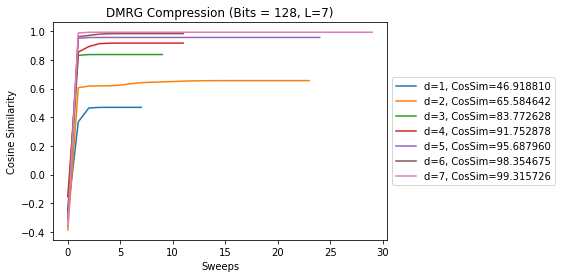

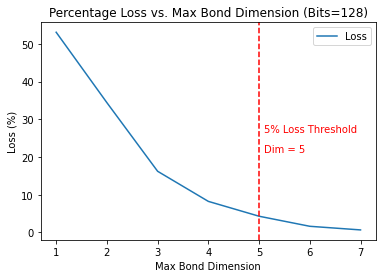

In [3]:
# Physical dimension
d = 2
data = rawData(bits=128, phys_dim=d)
compressed_data = compressedData(data.MPS, phys_dim=d)

# DMRG

In [4]:
def contract_L(bra, MPO, ket, site):  # Shape (bondW, bra_leg, ket_leg)
    for i in range(0, site):
        if i == site-1:  # We need to keep the extra leg from the bra
            if site == 1:  # L tensor is left bound only
                # Contracts to (bondW, a_1, a_1')
                pos = np.einsum('ij, ali, lm->ajm', bra[i], MPO[i], ket[i])
                # (a) bond to W, (j) leftover leg from bra, (m) leftover leg from ket
                L = pos
            else:
                pos = np.einsum('ijk, abkn, lmn->ialbjm', bra[i], MPO[i], ket[i])
                # (ial) will connect to previous L, (b) bond to W, (j) leftover bra leg, (m) leftover ket leg
                pos = np.reshape(pos, (pos.shape[0]*pos.shape[1]*pos.shape[2], pos.shape[3], pos.shape[4], pos.shape[5]))
                L = np.einsum('i, ibcd->bcd', L, pos)
        else:  # Normal tensor contraction at given position
            pos = contract_vertical(bra[i], MPO[i], dir='down')
            pos = contract_vertical(pos, ket[i], dir='down')
            if i == 0:  # Initialize L
                L = pos
            else:  # Add pos onto previous L
                L = contract_horizontal(L, pos, dir='right')
    return L

In [5]:
def contract_R(bra, MPO, ket, site):  # Shape (bondW, bra_leg, ket_leg)
    for i in range(len(bra)-1, site, -1):
        if i == site+1:  # We need to keep the extra leg from the bra
            if i == len(bra)-1:  # R tensor is the right bound only
                # Contracts to (bondW, a_1, a_1)
                pos = np.einsum('ij, ali, lm->ajm', bra[i], MPO[i], ket[i])
                # (a) bond to W, (j) leftover leg from bra, (m) leftover leg from ket
                R = pos
            else:
                pos = np.einsum('ijk, abkn, lmn->ailjbm', bra[i], MPO[i], ket[i])
                # (a) bond to W, (i) leftover leg from bra, (l) leftover leg from ket, (jbm) will connect to previous R
                pos = np.reshape(pos, (pos.shape[0], pos.shape[1], pos.shape[2], pos.shape[3]*pos.shape[4]*pos.shape[5]))
                R = np.einsum('ijkl, l->ijk', pos, R)
        else:  # Normal tensor contraction at given position
            pos = contract_vertical(bra[i], MPO[i], dir='down')
            pos = contract_vertical(pos, ket[i], dir='down')
            if i == len(bra)-1:  # Initialize R
                R = pos
            else: # Add pos onto previous R
                R = contract_horizontal(pos, R, dir='right')
    return R

In [6]:
# Tensor network with MPS site missing
def create_Hamiltonian(bra, MPO, ket, site):
    # Create L, R, and W for system
    if site != 0:
        L = contract_L(bra, MPO, ket, site)
    if site != len(bra)-1:
        R = contract_R(bra, MPO, ket, site)
    W = MPO[site]

    if site == 0:
        # (bondW, sigma_l', sigma_l) x (bondW, a_l, a_l')
        # -> (sigma_l, a_l, sigma_l', a_l')
        H = np.einsum('ijk, ibc->kbjc', W, R)
        H = np.reshape(H, (H.shape[0]*H.shape[1], H.shape[2]*H.shape[3]))
    elif site == len(bra)-1:
        # (bondW, a_(l-1), a_(l-1)') x (bondW, sigma_l', sigma_l)
        # -> (sigma_l, a_(l-1), sigma_l', a_(l-1)')
        H = np.einsum('ijk, ibc->cjbk', L, W)
        H = np.reshape(H, (H.shape[0]*H.shape[1], H.shape[2]*H.shape[3]))
    else:
        # (bondW, a_(l-1), a_(l-1)') x (bondL, bondR, sigma_l', sigma_l) x (bondW, a_l, a_l')
        # Shape (sigma_l, a_(l-1), a_l, sigma_l', a_(l-1)', a_l')
        H = np.einsum('ijk, ilcd, lmn->djmckn', L, W, R)
        H = np.reshape(H, (H.shape[0]*H.shape[1]*H.shape[2], H.shape[3]*H.shape[4]*H.shape[5]))
    return H

In [7]:
def update_site_DMRG(bra, MPO, ket, site, dir):
    # Hamiltonian without site to be updated
    H = create_Hamiltonian(bra, MPO, ket, site)

    # Initial eigenstate
    if bra[site].ndim == 2:
        v0 = np.reshape(bra[site], (bra[site].shape[0]*bra[site].shape[1]))
    elif bra[site].ndim == 3:
        # Needs shape v = (sigma, a_l-1, a_l)
        index_test = np.transpose(bra[site], (2, 0, 1))
        v0 = np.reshape(index_test, (index_test.shape[0]*index_test.shape[1]*index_test.shape[2]))
        #v0 = np.reshape(bra[site], (bra[site].shape[0]*bra[site].shape[1]*bra[site].shape[2]))

    E, V = sparse.linalg.eigsh(H, k=1, v0=v0, which='SA', tol=1E-8)
    # V is reshaped to be our updated site

    #updated_M = np.reshape(V, (bra[site].shape))

    if bra[site].ndim == 2:
        updated_M = np.reshape(V, (bra[site].shape))
    else:
        updated_M = np.reshape(V, (index_test.shape))
        updated_M = np.transpose(updated_M, (1, 2, 0))

    if dir == 'right':
        # Inner tensor needs to be reshaped
        if updated_M.ndim == 3:
            reshaped_M = np.transpose(updated_M, (0, 2, 1))  # Move left bond and physical dimension together
            reshaped_M = np.reshape(reshaped_M, (reshaped_M.shape[0]*reshaped_M.shape[1], reshaped_M.shape[2]))
            U, S_vector, V = np.linalg.svd(reshaped_M, full_matrices=False)
            A_tensor = np.reshape(U, (bra[site].shape[0], bra[site].shape[2], U.shape[1]))
            A_tensor = np.transpose(A_tensor, (0, 2, 1))
        else:
            U, S_vector, V = np.linalg.svd(updated_M, full_matrices=False)
            A_tensor = U

        lambda_tensor = np.diag(S_vector)

        if site == len(bra)-2:  # Multiplies with matrix on right bound (dim 2 x d)
            next_site_M = np.einsum('ij, jb, lb->li', lambda_tensor, V, bra[site+1])
        else:
            next_site_M = np.einsum('ij, jb, bmn->imn', lambda_tensor, V, bra[site+1])

        updated_site = A_tensor

    elif dir == 'left':
        if updated_M.ndim == 3:
            reshaped_M = np.reshape(updated_M, (updated_M.shape[0], updated_M.shape[1]*updated_M.shape[2]))
            U, S_vector, V = np.linalg.svd(reshaped_M, full_matrices=False)
            B_tensor = np.reshape(V, (V.shape[0], bra[site].shape[1], bra[site].shape[2]))
        else:
            U, S_vector, V = np.linalg.svd(updated_M.T, full_matrices=False)  # Transpose to have shape (2 x d)
            B_tensor = V.T

        lambda_tensor = np.diag(S_vector)

        if site == 1:
            next_site_M = np.einsum('ij, jb, bm->im', bra[site-1], U, lambda_tensor)
        else:
            next_site_M = np.einsum('ijk, jb, bm->imk', bra[site-1], U, lambda_tensor)

        updated_site = B_tensor

    return updated_site, next_site_M

In [8]:
# Generates right normalized MPS
L = 100
d = 2
MPS_original = randomState(num_sites=L, max_bond_dim=2, phys_dim=d).MPS
MPS = MPS_original[:]
#MPS = initialize_random_state(num_particles=L, bond_dim=2, phys_dim=d)
#MPS, _ = right_normalize(MPS_original)
MPO = initialize_quantum_ising(num_sites = L, g=2)
TN = Network(MPS, MPO, MPS)

In [9]:
def ground_state_search(bra, MPO, ket):
    threshold = 10e-8
    E = []
    E.append(calculate_expectation(MPS, MPO, MPS, vert_dir='down', horiz_dir='right'))
    while True:
        # Left->right sweep
        for site in range(0, len(MPS)-1):
            MPS[site], MPS[site+1] = update_site_DMRG(MPS, MPO, MPS, site=site, dir='right')
            E.append(calculate_expectation(MPS, MPO, MPS, vert_dir='down', horiz_dir='right')/scalar_product(MPS, MPS))

        # Right->left sweep
        for site in range(len(MPS)-1, 0, -1):
            MPS[site], MPS[site-1] = update_site_DMRG(MPS, MPO, MPS, site=site, dir='left')
        
            E.append(calculate_expectation(MPS, MPO, MPS, vert_dir='down', horiz_dir='right')/scalar_product(MPS, MPS))
        # Metrics are updated after each full sweep
        if np.abs(E[-2]-E[-1]) < threshold:
            break
    return E

In [10]:
ground_state_search(MPS, MPO, MPS)

In [11]:
E[-1]

NameError: name 'E' is not defined